<a href="https://colab.research.google.com/github/AkshayAgr/rossmann-sales-prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [37]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from sklearn.linear_model import LinearRegression
import datetime as dt
import calendar
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
import xgboost as xg
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [38]:
# Mount your drive and read the csv file. Make sure you are using the correct file path
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/AlmaBetter/'
sales_raw_data = pd.read_csv(drive_path + 'Rossmann Stores Data.csv')
sales_raw_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [39]:
stores_raw_data = pd.read_csv(drive_path + 'store.csv')
stores_raw_data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [40]:
sales_raw_data.dtypes, stores_raw_data.dtypes

(Store             int64
 DayOfWeek         int64
 Date             object
 Sales             int64
 Customers         int64
 Open              int64
 Promo             int64
 StateHoliday     object
 SchoolHoliday     int64
 dtype: object, Store                          int64
 StoreType                     object
 Assortment                    object
 CompetitionDistance          float64
 CompetitionOpenSinceMonth    float64
 CompetitionOpenSinceYear     float64
 Promo2                         int64
 Promo2SinceWeek              float64
 Promo2SinceYear              float64
 PromoInterval                 object
 dtype: object)

There are 6 columns with Null values. 

In [41]:
print(sales_raw_data.isnull().sum()), print(stores_raw_data.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


(None, None)

Convert date column of sales data to date data type and find minimum and maximum date.

In [42]:
sales_data = sales_raw_data.copy()
sales_data['Date']= pd.to_datetime(sales_data['Date'])
min_date = min(sales_data['Date'])
max_date = max(sales_data['Date'])
min_date, max_date

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

State holiday column in sales data has 2 kinds of zeroes. One is numeric and other is character.

In [43]:
sales_data['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

Make changes to Stores data.

In [44]:
stores_data = stores_raw_data.copy()
stores_data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Create a new variable 'CompetitionExist'. If CompetitionDistance is Null, CompetitionExist = 0 and CompetitionExist = 1 if not.

In [45]:
stores_data['CompetitionExist'] = 1
stores_data.loc[stores_data['CompetitionDistance'].isnull() == True, 'CompetitionExist'] = 0

In [46]:
stores_data[stores_data['CompetitionDistance'].isnull() == True]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionExist
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,0
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN,0
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov",0


If CompetitionDistance is Null, fill CompetitionOpenSinceMonth = 12 and CompetitionOpenSinceYear = 2015. This way the start of competition of these stores will be more than maximum date of the dataset.

In [47]:
stores_data[stores_data['CompetitionDistance'].isnull() == True]['CompetitionOpenSinceMonth'].fillna(12, inplace = True)
stores_data[stores_data['CompetitionDistance'].isnull() == True]['CompetitionOpenSinceYear'].fillna(2015, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Fill CompetitionDistance with Maximum distance where CompetitionDistance is Null.

In [48]:
max_distance = max(stores_data['CompetitionDistance'])
stores_data['CompetitionDistance'].fillna(max_distance, inplace = True)

Fill remaining null values CompetitionOpenSinceMonth and CompetitionOpenSinceYear with month and year of Minimum date of dataset. 

In [49]:
stores_data['CompetitionOpenSinceMonth'].fillna(1, inplace = True)
stores_data['CompetitionOpenSinceYear'].fillna(2013, inplace = True)

Create a new column 'CompetitionStartDate'.

In [50]:
stores_data['CompetitionStartDate'] = pd.to_datetime(stores_data['CompetitionOpenSinceYear'] * 10000 + stores_data['CompetitionOpenSinceMonth'] * 100 + 1, format='%Y%m%d')

Fill Null values of Promo2SinceWeek and Promo2SinceYear with 53 and 2015. Fill Null values of PromoInterval to 'None'. 

In [51]:
stores_data['Promo2SinceWeek'].fillna(53, inplace = True)
stores_data['Promo2SinceYear'].fillna(2015, inplace = True)
stores_data['PromoInterval'].fillna('None', inplace = True)

Convert Promo2SinceWeek and Promo2SinceYear to int datatype

In [52]:
stores_data['Promo2SinceWeek'] = stores_data['Promo2SinceWeek'].astype(int)
stores_data['Promo2SinceYear'] = stores_data['Promo2SinceYear'].astype(int)

Add new column Promo2StartDate which signifies the first date of Promo2.

In [53]:
stores_data['Promo2StartDate'] = pd.to_datetime(stores_data['Promo2SinceWeek'].astype(str) + stores_data['Promo2SinceYear'].astype(str).add('-1'), format='%V%G-%u')

All null values are removes from Stores data. 

In [54]:
print(stores_data.isnull().sum())

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
CompetitionExist             0
CompetitionStartDate         0
Promo2StartDate              0
dtype: int64


In [55]:
stores_data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionExist,CompetitionStartDate,Promo2StartDate
0,1,c,a,1270.0,9.0,2008.0,0,53,2015,None,1,2008-09-01,2015-12-28
1,2,a,a,570.0,11.0,2007.0,1,13,2010,"Jan,Apr,Jul,Oct",1,2007-11-01,2010-03-29
2,3,a,a,14130.0,12.0,2006.0,1,14,2011,"Jan,Apr,Jul,Oct",1,2006-12-01,2011-04-04
3,4,c,c,620.0,9.0,2009.0,0,53,2015,None,1,2009-09-01,2015-12-28
4,5,a,a,29910.0,4.0,2015.0,0,53,2015,None,1,2015-04-01,2015-12-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31,2013,"Jan,Apr,Jul,Oct",1,2014-06-01,2013-07-29
1111,1112,c,c,1880.0,4.0,2006.0,0,53,2015,None,1,2006-04-01,2015-12-28
1112,1113,a,c,9260.0,1.0,2013.0,0,53,2015,None,1,2013-01-01,2015-12-28
1113,1114,a,c,870.0,1.0,2013.0,0,53,2015,None,1,2013-01-01,2015-12-28


Create new table stores_data_merge by removing competition and promo month, year and week columns.

In [56]:
stores_data_merge = stores_data.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear'], axis = 1)

In [57]:
stores_data_merge

,Store,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,CompetitionExist,CompetitionStartDate,Promo2StartDate
0,1,c,a,1270.0,0,None,1,2008-09-01,2015-12-28
1,2,a,a,570.0,1,"Jan,Apr,Jul,Oct",1,2007-11-01,2010-03-29
2,3,a,a,14130.0,1,"Jan,Apr,Jul,Oct",1,2006-12-01,2011-04-04
3,4,c,c,620.0,0,None,1,2009-09-01,2015-12-28
4,5,a,a,29910.0,0,None,1,2015-04-01,2015-12-28
...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,1,"Jan,Apr,Jul,Oct",1,2014-06-01,2013-07-29
1111,1112,c,c,1880.0,0,None,1,2006-04-01,2015-12-28
1112,1113,a,c,9260.0,0,None,1,2013-01-01,2015-12-28
1113,1114,a,c,870.0,0,None,1,2013-01-01,2015-12-28


Merge stores_data_merge with sales_data.

In [58]:
sales_data_merged = pd.merge(sales_data, stores_data_merge, on='Store')

Create new column 'CompetitionActive'. It's 1 if CompetitionStartDate <= Date and 0 if not.

In [59]:
sales_data_merged['CompetitionActive'] = [(i <= j) for i,j in zip(sales_data_merged['CompetitionStartDate'], sales_data_merged['Date']) ]

Create column month_name to extract month from Date column.

In [60]:
sales_data_merged['month_name'] = sales_data_merged['Date'].dt.month.apply(lambda x: calendar.month_abbr[x]) 

Create column Promo2MonthMatch to match month of Date and Values in PromoInterval columns.

In [61]:
sales_data_merged['Promo2MonthMatch'] = [(i in j) for i,j in zip(sales_data_merged['month_name'], sales_data_merged['PromoInterval']) ]

Create column Promo2Started. If Promo2StartDate <= Date,  Promo2Started is 1 and 0 otherwise.

In [62]:
sales_data_merged['Promo2Started'] = [(i <= j) for i,j in zip(sales_data_merged['Promo2StartDate'], sales_data_merged['Date']) ]

Create column Promo2Active. If Promo2MonthMatch = True and Promo2Started = True,  Promo2Started is 1 and 0 otherwise.

In [63]:
sales_data_merged['Promo2Active'] = [(i & j) for i,j in zip(sales_data_merged['Promo2MonthMatch'], sales_data_merged['Promo2Started']) ]

Create column DateDiff. It is difference of Date from minimum date.

In [64]:
sales_data_merged['DateDiff'] = (sales_data_merged['Date'] - min_date).dt.days

Convert datatypes of columns.

In [65]:
sales_data_merged['DayOfWeek'] = sales_data_merged['DayOfWeek'].astype(str)
sales_data_merged['StateHoliday'] = sales_data_merged['StateHoliday'].astype(str)
sales_data_merged['SchoolHoliday'] = sales_data_merged['SchoolHoliday'].astype(str)
sales_data_merged['CompetitionActive'] = sales_data_merged['CompetitionActive'].astype(int)
sales_data_merged['Promo2Active'] = sales_data_merged['Promo2Active'].astype(int)

In [66]:
sales_data_merged

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,CompetitionExist,CompetitionStartDate,Promo2StartDate,CompetitionActive,month_name,Promo2MonthMatch,Promo2Started,Promo2Active,DateDiff
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,None,1,2008-09-01,2015-12-28,1,Jul,False,False,0,941
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,None,1,2008-09-01,2015-12-28,1,Jul,False,False,0,940
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,None,1,2008-09-01,2015-12-28,1,Jul,False,False,0,939
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,None,1,2008-09-01,2015-12-28,1,Jul,False,False,0,938
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,None,1,2008-09-01,2015-12-28,1,Jul,False,False,0,937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,...,"Mar,Jun,Sept,Dec",1,2013-01-01,2012-05-28,1,Jan,False,True,0,4
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,...,"Mar,Jun,Sept,Dec",1,2013-01-01,2012-05-28,1,Jan,False,True,0,3
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,...,"Mar,Jun,Sept,Dec",1,2013-01-01,2012-05-28,1,Jan,False,True,0,2
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,...,"Mar,Jun,Sept,Dec",1,2013-01-01,2012-05-28,1,Jan,False,True,0,1


In [67]:
sales_data_merged.dtypes

Store                            int64
DayOfWeek                       object
Date                    datetime64[ns]
Sales                            int64
Customers                        int64
Open                             int64
Promo                            int64
StateHoliday                    object
SchoolHoliday                   object
StoreType                       object
Assortment                      object
CompetitionDistance            float64
Promo2                           int64
PromoInterval                   object
CompetitionExist                 int64
CompetitionStartDate    datetime64[ns]
Promo2StartDate         datetime64[ns]
CompetitionActive                int64
month_name                      object
Promo2MonthMatch                  bool
Promo2Started                     bool
Promo2Active                     int64
DateDiff                         int64
dtype: object

Extract required columns from sales_data_merged.

In [111]:
sales_data_final = sales_data_merged[['Store', 'Sales', 'Customers', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                                      'CompetitionDistance', 'CompetitionActive', 'Promo2Active', 'DateDiff']]

In [112]:
sales_data_final.describe()

,Store,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionActive,Promo2Active,DateDiff
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,5.613013e+03,9.167664e-01,1.494796e-01,4.650630e+02
std,3.219087e+02,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,8.498338e+03,2.762352e-01,3.565608e-01,2.744541e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,7.100000e+02,1.000000e+00,0.000000e+00,2.280000e+02
50%,5.580000e+02,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,2.330000e+03,1.000000e+00,0.000000e+00,4.560000e+02
75%,8.380000e+02,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,6.910000e+03,1.000000e+00,0.000000e+00,7.100000e+02
max,1.115000e+03,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,7.586000e+04,1.000000e+00,1.000000e+00,9.410000e+02


Correlation of numerical variables.

In [113]:
lin_num_vars = sales_data_final
lin_num_vars = lin_num_vars[['Sales', 'Customers', 'CompetitionDistance', 'DateDiff']]
lin_num_vars.corr()

,Sales,Customers,CompetitionDistance,DateDiff
Sales,1.000000,0.894711,-0.024339,0.041904
Customers,0.894711,1.000000,-0.101331,0.012679
CompetitionDistance,-0.024339,-0.101331,1.000000,0.001370
DateDiff,0.041904,0.012679,0.001370,1.000000


Sales and Customers are highly correlated. We can use both of these as dependent variables.

In [114]:
store_cd = pd.pivot_table(sales_data_final, index =['Store'], values = ['Sales', 'Customers', 'CompetitionDistance'], aggfunc='mean')
date_cd = pd.pivot_table(sales_data_final, index =['DateDiff'], values = ['Sales', 'Customers'], aggfunc='mean')
date_cd['Dates'] = date_cd.index

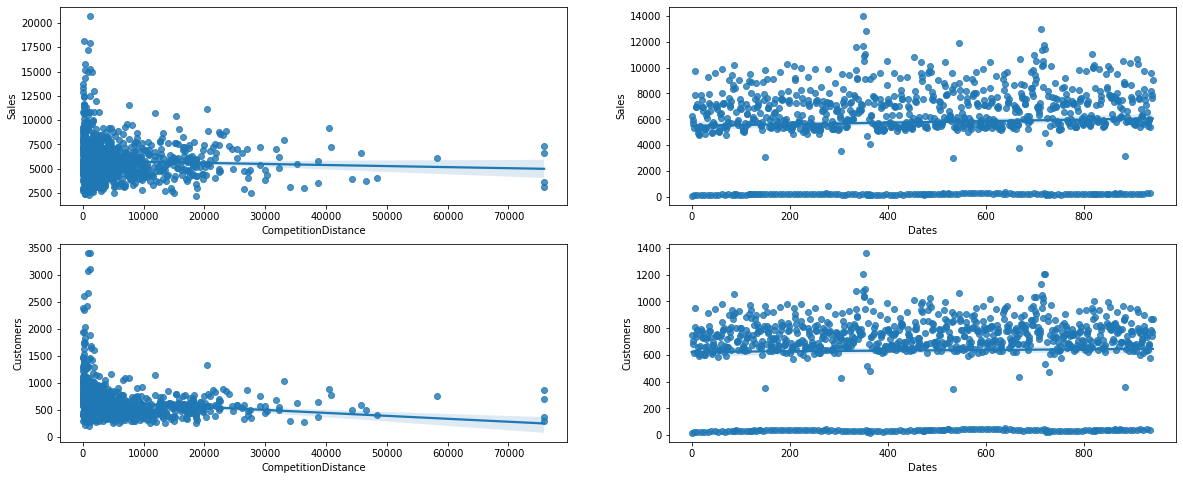

In [115]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,8))
sns.regplot(x = 'CompetitionDistance', y = 'Sales', data = store_cd, ax = ax1)
sns.regplot(x = 'Dates', y = 'Sales', data = date_cd, ax = ax2)
sns.regplot(x = 'CompetitionDistance', y = 'Customers', data = store_cd, ax = ax3)
sns.regplot(x = 'Dates', y = 'Customers', data = date_cd, ax = ax4)
plt.show()


Histograms of Sales and Customers.

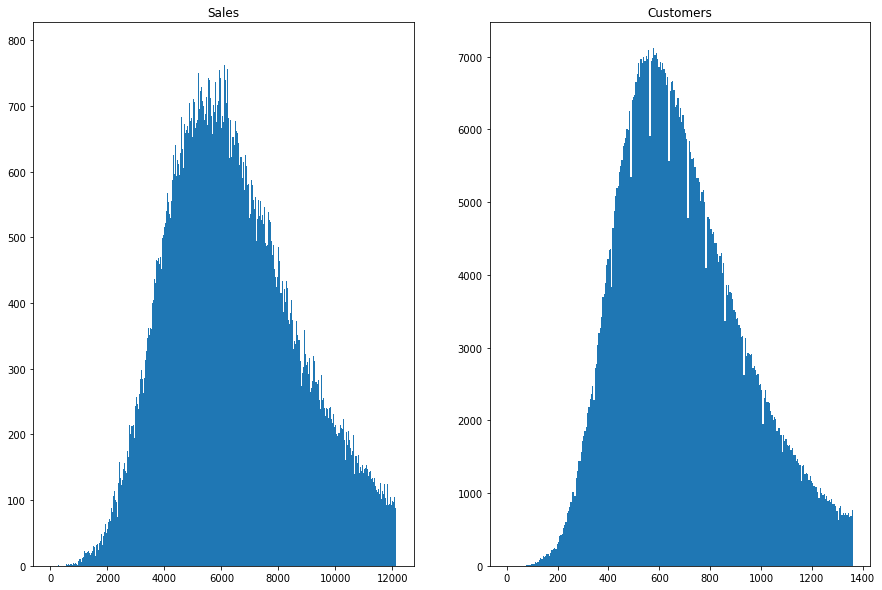

In [116]:
fig, ((ax0, ax1)) = plt.subplots(figsize =(15, 10), nrows=1, ncols=2)
ax0.hist(lin_num_vars['Sales'], bins = range(1, int(np.percentile(lin_num_vars['Sales'], 95) ), 5) )
ax0.set_title('Sales')

ax1.hist(lin_num_vars['Customers'], bins = range(1, int(np.percentile(lin_num_vars['Customers'], 95) ), 5) )
ax1.set_title('Customers')

# Show plot
plt.show()

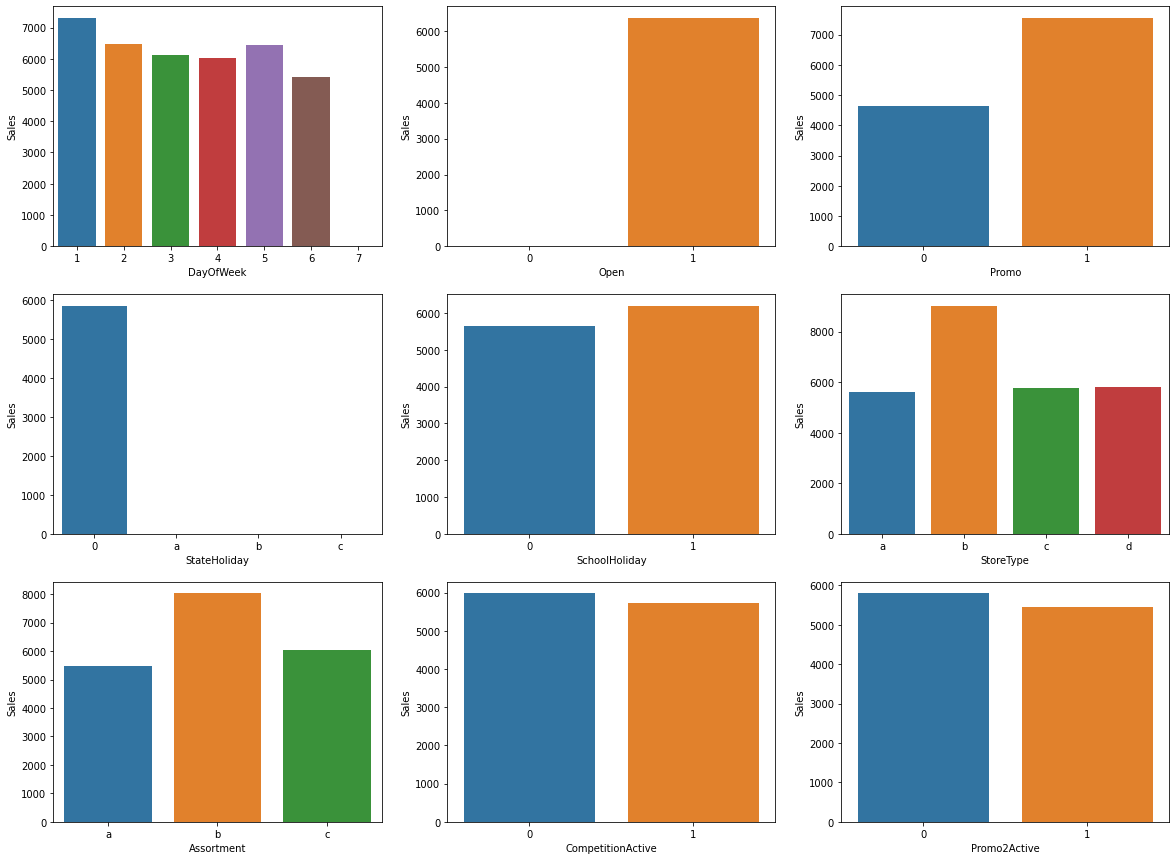

In [121]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(20,15))

week_day = pd.pivot_table(sales_data_final, index =['DayOfWeek'], values = ['Sales'], aggfunc='median')
week_day['DayOfWeek'] = week_day.index
sns.barplot(ax=ax1, data=week_day, x='DayOfWeek', y='Sales')

open_day = pd.pivot_table(sales_data_final, index =['Open'], values = ['Sales'], aggfunc='median')
open_day['Open'] = open_day.index
sns.barplot(ax=ax2, data=open_day, x='Open', y='Sales')

Promo_data = pd.pivot_table(sales_data_final, index =['Promo'], values = ['Sales'], aggfunc='median')
Promo_data['Promo'] = Promo_data.index
sns.barplot(ax=ax3, data=Promo_data, x='Promo', y='Sales')

StateHoliday_data = pd.pivot_table(sales_data_final, index =['StateHoliday'], values = ['Sales'], aggfunc='median')
StateHoliday_data['StateHoliday'] = StateHoliday_data.index
sns.barplot(ax=ax4, data=StateHoliday_data, x='StateHoliday', y='Sales')

SchoolHoliday_data = pd.pivot_table(sales_data_final, index =['SchoolHoliday'], values = ['Sales'], aggfunc='median')
SchoolHoliday_data['SchoolHoliday'] = SchoolHoliday_data.index
sns.barplot(ax=ax5, data=SchoolHoliday_data, x='SchoolHoliday', y='Sales')

StoreType_data = pd.pivot_table(sales_data_final, index =['StoreType'], values = ['Sales'], aggfunc='median')
StoreType_data['StoreType'] = StoreType_data.index
sns.barplot(ax=ax6, data=StoreType_data, x='StoreType', y='Sales')

Assortment_data = pd.pivot_table(sales_data_final, index =['Assortment'], values = ['Sales'], aggfunc='median')
Assortment_data['Assortment'] = Assortment_data.index
sns.barplot(ax=ax7, data=Assortment_data, x='Assortment', y='Sales')

CompetitionActive_data = pd.pivot_table(sales_data_final, index =['CompetitionActive'], values = ['Sales'], aggfunc='median')
CompetitionActive_data['CompetitionActive'] = CompetitionActive_data.index
sns.barplot(ax=ax8, data=CompetitionActive_data, x='CompetitionActive', y='Sales')

Promo2Active_data = pd.pivot_table(sales_data_final, index =['Promo2Active'], values = ['Sales'], aggfunc='median')
Promo2Active_data['Promo2Active'] = Promo2Active_data.index
sns.barplot(ax=ax9, data=Promo2Active_data, x='Promo2Active', y='Sales')

plt.show()

There are no sales when stores are closed.

In [72]:
sales_data_final[sales_data_final['Open'] == 0]['Customers'].sum(), sales_data_final[sales_data_final['Open'] == 0]['Sales'].sum()

(0, 0)

Remove rows from sales data when stores are closed and then remove open column.

In [73]:
sales_data_final = sales_data_final[sales_data_final['Open'] == 1 ]
sales_data_final = sales_data_final.drop(['Open'], axis=1)

There are days when stores are open but the sales are 0.

In [74]:
sales_data_final[sales_data_final['Sales'] ==0].shape

(54, 13)

In [75]:
sales_data_final.shape

(844392, 13)

Next is selection of train and test data for the models. We need a model that can predict sales for next 6 weeks. The dataset has 942 days of sales. We will take last 42 days as test data and 730 days before that as training data. By using 730 days, I am using 2 years of data for training the model. 

In [76]:
y = sales_data_final['Sales']
x = sales_data_final

Getting dummies for categorical variables.

In [77]:
x = pd.get_dummies(x)
x.columns

Index(['Store', 'Sales', 'Customers', 'Promo', 'CompetitionDistance',
       'CompetitionActive', 'Promo2Active', 'DateDiff', 'DayOfWeek_1',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c', 'SchoolHoliday_0',
       'SchoolHoliday_1', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c'],
      dtype='object')

Train test split

In [78]:
train_index = (x['DateDiff'] < 900) & (x['DateDiff'] >= 170)
test_index = x['DateDiff'] >= 900

In [79]:
x_train = x[train_index]
x_test = x[test_index]

y_train = pd.DataFrame(y[train_index])
y_test = pd.DataFrame(y[test_index])

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((648712, 28), (40282, 28), (648712, 1), (40282, 1))

Creating a new column 'MeanSales'. MeanSales are average of daily sales for each store. This is calculated from training data. 

In [80]:
x_train_mean_sales = pd.pivot_table(x_train, index =['Store'], values = ['Sales'], aggfunc='mean')
x_train_mean_sales = x_train_mean_sales.rename({'Sales': 'MeanSales'}, axis=1)
x_train_mean_sales['Store'] = x_train_mean_sales.index
x_train_mean_sales.index = range(1115)

x_train = pd.merge(x_train_mean_sales, x_train, on='Store')
x_test = pd.merge(x_train_mean_sales, x_test, on='Store')

Removing those columns from traing and test data which are not required.

In [81]:
x_train = x_train.drop(['Store', 'Sales', 'Customers','DayOfWeek_7', 'StateHoliday_c', 'SchoolHoliday_0', 'StoreType_d', 'Assortment_c'], axis = 1)
x_test = x_test.drop(['Store', 'Sales', 'Customers','DayOfWeek_7', 'StateHoliday_c', 'SchoolHoliday_0', 'StoreType_d', 'Assortment_c'], axis = 1)

In [82]:
x_test.columns, x_train.columns

(Index(['MeanSales', 'Promo', 'CompetitionDistance', 'CompetitionActive',
        'Promo2Active', 'DateDiff', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
        'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'StateHoliday_0',
        'StateHoliday_a', 'StateHoliday_b', 'SchoolHoliday_1', 'StoreType_a',
        'StoreType_b', 'StoreType_c', 'Assortment_a', 'Assortment_b'],
       dtype='object'),
 Index(['MeanSales', 'Promo', 'CompetitionDistance', 'CompetitionActive',
        'Promo2Active', 'DateDiff', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
        'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'StateHoliday_0',
        'StateHoliday_a', 'StateHoliday_b', 'SchoolHoliday_1', 'StoreType_a',
        'StoreType_b', 'StoreType_c', 'Assortment_a', 'Assortment_b'],
       dtype='object'))

Standardizing training data and test data for linear regression and fitting the same.

In [83]:
scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

scaler_y = StandardScaler()
y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train), columns=y_train.columns)
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test), columns=y_test.columns)
linear_regressor = LinearRegression()
linear_regressor.fit(x_train_scaled, y_train_scaled)

LinearRegression()

In [135]:
linear_regressor.coef_.flatten()

array([ 7.70212378e-01,  3.69079027e-01, -1.21523820e-04, -1.61070906e-02,
       -1.03981274e-02,  4.25414292e-02,  6.29510527e-02, -7.16421526e-02,
       -1.14539282e-01, -1.15335825e-01, -6.92362816e-02, -6.55198407e-02,
       -8.83541446e-03, -4.37350818e-03, -2.47914511e-03,  1.89764091e-02,
       -7.16174536e-04,  2.80267305e-03, -7.40031720e-04, -8.16516171e-04,
        3.85361847e-04])

In [137]:
pd.DataFrame({'Feature':linear_regressor.feature_names_in_, 'Coefficients':linear_regressor.coef_.flatten()})

,Feature,Coefficients
0,MeanSales,0.770212
1,Promo,0.369079
2,CompetitionDistance,-0.000122
3,CompetitionActive,-0.016107
4,Promo2Active,-0.010398
5,DateDiff,0.042541
6,DayOfWeek_1,0.062951
7,DayOfWeek_2,-0.071642
8,DayOfWeek_3,-0.114539
9,DayOfWeek_4,-0.115336


In [138]:
y_pred_scaled = linear_regressor.predict(x_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_train_pred_scaled = linear_regressor.predict(x_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

0.80154234964181
0.8055710355249623
1360.8145083402612
1524.7640278009437
AxesSubplot(0.125,0.125;0.775x0.755)


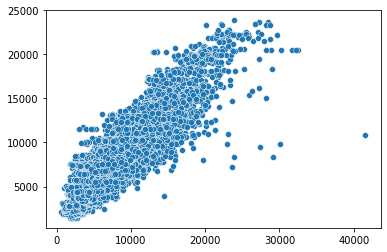

In [139]:
print(r2_score(np.array(y_test), y_pred) )
print(explained_variance_score(np.array(y_test), y_pred) )
print(np.sqrt(mean_squared_error(np.array(y_test), y_pred) ) )
print(np.sqrt(mean_squared_error(np.array(y_train), y_train_pred) ) )
print(sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten() ) )

In [86]:
lasso_model = Lasso()
lasso_alpha = dict()
lasso_alpha['alpha'] = np.arange(0, 0.005, 0.001)
lasso_grid = GridSearchCV( lasso_model, lasso_alpha ) 

In [87]:
lasso_grid.fit( x_train_scaled, y_train_scaled )

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.353e+04, tolerance: 5.550e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([0.   , 0.001, 0.002, 0.003, 0.004])})

In [88]:
lasso_grid.best_params_

{'alpha': 0.001}

In [89]:
y_pred_scaled = lasso_grid.predict(x_test_scaled)
y_pred = scaler_y.inverse_transform(pd.DataFrame(y_pred_scaled) )

y_train_pred_scaled = lasso_grid.predict(x_train_scaled)
y_train_pred = scaler_y.inverse_transform(pd.DataFrame(y_train_pred_scaled))

0.8016554527919283
0.8053914777973643
1360.426681661175
1525.250015939472
AxesSubplot(0.125,0.125;0.775x0.755)


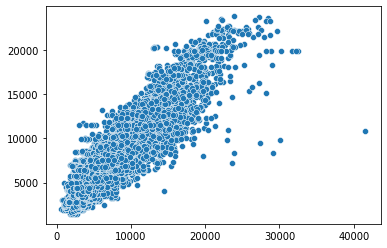

In [90]:
print(r2_score(np.array(y_test), y_pred) )
print(explained_variance_score(np.array(y_test), y_pred) )
print(np.sqrt(mean_squared_error(np.array(y_test), y_pred) ) )
print(np.sqrt(mean_squared_error(np.array(y_train), y_train_pred) ) )
print(sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten() ) )

In [91]:
ridge_model = Ridge()
ridge_alpha = dict()
ridge_alpha['alpha'] = np.arange(2397.75, 2398.25, 0.25)
ridge_grid = GridSearchCV( ridge_model, ridge_alpha ) 

In [92]:
ridge_grid.fit( x_train_scaled, y_train_scaled )

GridSearchCV(estimator=Ridge(), param_grid={'alpha': array([2397.75, 2398.  ])})

In [93]:
ridge_grid.best_params_

{'alpha': 2398.0}

In [94]:
y_pred_scaled = ridge_grid.predict(x_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_train_pred_scaled = ridge_grid.predict(x_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

0.8015496293823376
0.8055489512000847
1360.789549697054
1524.8695420906506
AxesSubplot(0.125,0.125;0.775x0.755)


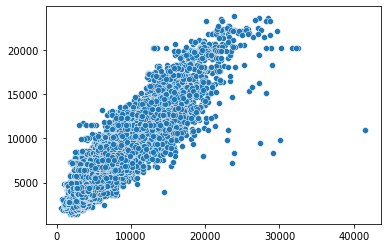

In [95]:
print(r2_score(np.array(y_test), y_pred) )
print(explained_variance_score(np.array(y_test), y_pred) )
print(np.sqrt(mean_squared_error(np.array(y_test), y_pred) ) )
print(np.sqrt(mean_squared_error(np.array(y_train), y_train_pred) ) )
print(sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten() ) )

In [96]:
# create regressor object
forest_regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
forest_regressor.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(random_state=0)

(0.8083755698447724,
 0.8111826967045853,
 1337.1817678056589,
 310.3929277080003,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f70927cb2d0>)

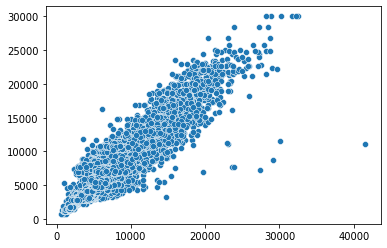

In [98]:
y_pred = forest_regressor.predict(x_test)
y_train_pred = forest_regressor.predict(x_train)
r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred) ), np.sqrt(mean_squared_error(y_train, y_train_pred) ), sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten())

In [101]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', seed = 123)
xgb_hyper = dict()
xgb_hyper['n_estimators'] = [150]

xgb_grid = GridSearchCV( xgb_r, xgb_hyper ) 

In [102]:
xgb_grid.fit(x_train, y_train)

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', seed=123),
             param_grid={'n_estimators': [150]})

In [103]:
xgb_grid.best_params_

{'n_estimators': 150}

In [104]:
xgb_grid.best_score_

0.839874721838228

(0.8284560370298463,
 0.8284974503172721,
 1265.1811935737944,
 1224.0187923556819,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb051fa3d90>)

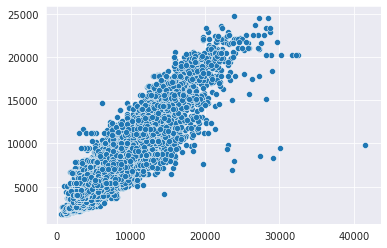

In [105]:
y_pred = xgb_grid.predict(x_test)
y_train_pred = xgb_grid.predict(x_train)
r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred) ), np.sqrt(mean_squared_error(y_train, y_train_pred) ), sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten())

In [69]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', seed = 123)
xgb_hyper = dict()
xgb_hyper['learning_rate'] = [0.1]
xgb_hyper['n_estimators'] = [150]
xgb_hyper['max_depth'] = [5]
xgb_hyper['min_child_weight'] = [1]
xgb_hyper['gamma'] = [0]
xgb_hyper['subsample'] = [0.8]
xgb_hyper['colsample_bytree'] = [0.8]

xgb_grid = GridSearchCV( xgb_r, xgb_hyper ) 

In [70]:
xgb_grid.fit(x_train, y_train)

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', seed=123),
             param_grid={'colsample_bytree': [0.8], 'gamma': [0],
                         'learning_rate': [0.1], 'max_depth': [5],
                         'min_child_weight': [1], 'n_estimators': [150],
                         'subsample': [0.8]})

In [71]:
xgb_grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 150,
 'subsample': 0.8}

In [74]:
xgb_grid.best_score_

0.8692294341292396

(0.8473076818023093,
 0.8473104156611573,
 1193.6406557939679,
 1065.8681349944334,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb0d3d09590>)

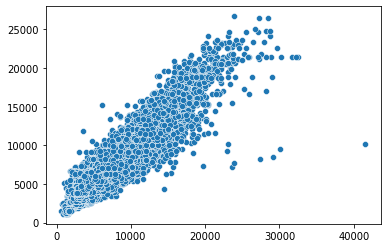

In [75]:
y_pred = xgb_grid.predict(x_test)
y_train_pred = xgb_grid.predict(x_train)
r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred) ), np.sqrt(mean_squared_error(y_train, y_train_pred) ), sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten())

In [76]:
xgb_hyper['max_depth'] = [4,5,6]
xgb_hyper['min_child_weight'] = [4,5,6]
xgb_grid = GridSearchCV( xgb_r, xgb_hyper ) 
xgb_grid.fit(x_train, y_train)

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', seed=123),
             param_grid={'colsample_bytree': [0.8], 'gamma': [0],
                         'learning_rate': [0.1], 'max_depth': [4, 5, 6],
                         'min_child_weight': [4, 5, 6], 'n_estimators': [150],
                         'subsample': [0.8]})

In [77]:
xgb_grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 150,
 'subsample': 0.8}

In [78]:
xgb_grid.best_score_

0.875688835641987

(0.8494624630498415,
 0.8506854986559904,
 1185.1884520007072,
 1002.4994830072344,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb0d3c16410>)

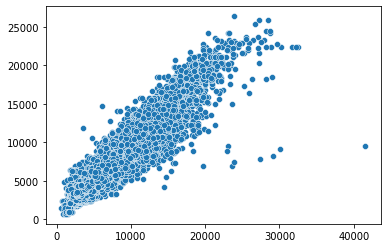

In [79]:
y_pred = xgb_grid.predict(x_test)
y_train_pred = xgb_grid.predict(x_train)
r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred) ), np.sqrt(mean_squared_error(y_train, y_train_pred) ), sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten())

In [80]:
xgb_hyper['max_depth'] = [6]
xgb_hyper['min_child_weight'] = [5]
xgb_hyper['gamma'] = [0, 0.1, 0.2]
xgb_grid = GridSearchCV( xgb_r, xgb_hyper ) 
xgb_grid.fit(x_train, y_train)

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', seed=123),
             param_grid={'colsample_bytree': [0.8], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.1], 'max_depth': [6],
                         'min_child_weight': [5], 'n_estimators': [150],
                         'subsample': [0.8]})

In [81]:
xgb_grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 150,
 'subsample': 0.8}

In [82]:
xgb_grid.best_score_

0.875688835641987

(0.8494624630498415,
 0.8506854986559904,
 1185.1884520007072,
 1002.4994830072344,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb0d3bd1b10>)

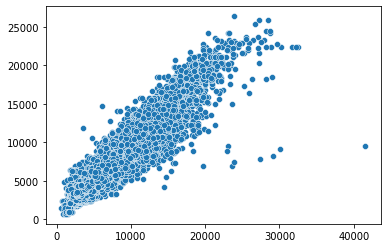

In [83]:
y_pred = xgb_grid.predict(x_test)
y_train_pred = xgb_grid.predict(x_train)
r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred) ), np.sqrt(mean_squared_error(y_train, y_train_pred) ), sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten())

In [84]:
xgb_hyper['gamma'] = [0]
xgb_hyper['subsample'] = [0.7, 0.8, 0.9]
xgb_hyper['colsample_bytree'] = [0.7, 0.8, 0.9]
xgb_grid = GridSearchCV( xgb_r, xgb_hyper ) 
xgb_grid.fit(x_train, y_train)

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', seed=123),
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9], 'gamma': [0],
                         'learning_rate': [0.1], 'max_depth': [6],
                         'min_child_weight': [5], 'n_estimators': [150],
                         'subsample': [0.7, 0.8, 0.9]})

In [85]:
xgb_grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 150,
 'subsample': 0.9}

In [86]:
xgb_grid.best_score_

0.8757441063504391

(0.8508230029978485,
 0.8508958433853011,
 1179.820501216975,
 1006.1230506327062,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb0d3bb0ed0>)

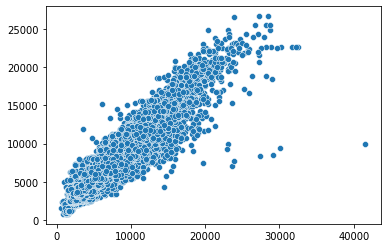

In [87]:
y_pred = xgb_grid.predict(x_test)
y_train_pred = xgb_grid.predict(x_train)
r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred) ), np.sqrt(mean_squared_error(y_train, y_train_pred) ), sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten())

In [88]:
xgb_hyper['subsample'] = [0.85, 0.9, 0.95]
xgb_hyper['colsample_bytree'] = [0.75, 0.8, 0.85]
xgb_grid = GridSearchCV( xgb_r, xgb_hyper ) 
xgb_grid.fit(x_train, y_train)

GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', seed=123),
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85], 'gamma': [0],
                         'learning_rate': [0.1], 'max_depth': [6],
                         'min_child_weight': [5], 'n_estimators': [150],
                         'subsample': [0.85, 0.9, 0.95]})

In [100]:
xgb_grid.param_grid

{'n_estimators': [150]}

In [96]:
xgb_grid.best_score_

AttributeError: ignored

(0.8510287336381741,
 0.8512354824726578,
 1179.0066727592643,
 1003.3648791635935,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb0d47f2f50>)

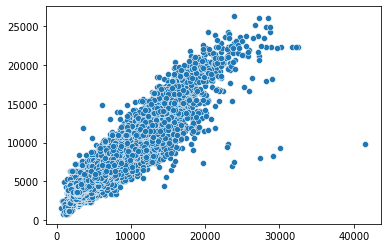

In [91]:
y_pred = xgb_grid.predict(x_test)
y_train_pred = xgb_grid.predict(x_train)
r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred) ), np.sqrt(mean_squared_error(y_train, y_train_pred) ), sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten())

In [94]:
#pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.9 MB/s 


In [111]:
xgb_final = xg.XGBRegressor(objective ='reg:squarederror', seed = 123, colsample_bytree = 0.8, gamma = 0,
                        learning_rate = 0.1, max_depth = 6, min_child_weight = 5, n_estimators = 150, subsample = 0.9 )

xgb_final.fit(x_train, y_train)

XGBRegressor(colsample_bytree=0.8, max_depth=6, min_child_weight=5,
             n_estimators=150, objective='reg:squarederror', seed=123,
             subsample=0.9)

(0.8508230029978485,
 0.8508958433853011,
 1179.820501216975,
 1006.1230506327062,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb051dfd4d0>)

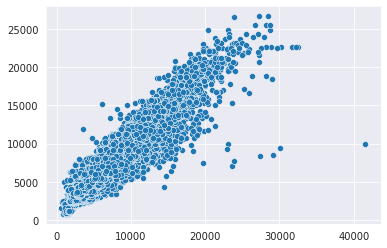

In [112]:
y_pred = xgb_final.predict(x_test)
y_train_pred = xgb_final.predict(x_train)
r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred) ), np.sqrt(mean_squared_error(y_train, y_train_pred) ), sns.scatterplot(x = y_test.to_numpy().flatten(), y = y_pred.flatten())

In [95]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
import shap 
import graphviz
sns.set_style('darkgrid') 

In [115]:
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
# Define a tree explainer for the built model
#shap_values = shap.TreeExplainer(xgb_final).shap_values(x_test)
#shap.summary_plot(shap_values[0], x_test) 

explainer = shap.Explainer(xgb_final)
shap_values = explainer(x_train)

In [124]:
shap_values

NameError: ignored

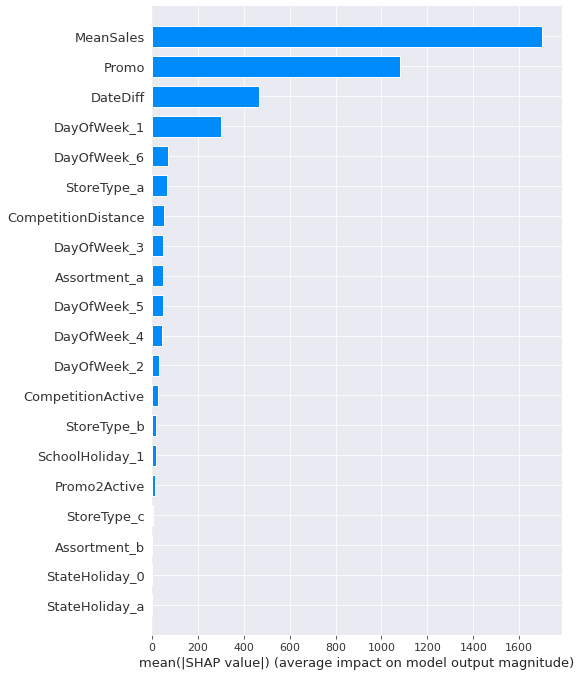

In [118]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

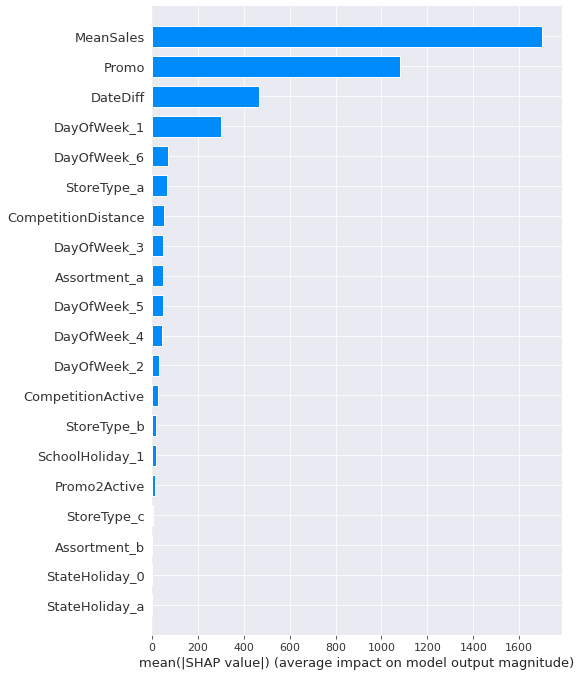

In [119]:
shap.summary_plot(shap_values, x_test, plot_type="bar")